In [28]:
import os
import requests
from pyspark.sql import SparkSession
from tmlt.analytics.keyset import KeySet
from tmlt.analytics.privacy_budget import PureDPBudget
from tmlt.analytics.query_builder import QueryBuilder
from tmlt.analytics.session import Session

# r = requests.get(
#     'https://tumult-public.s3.amazonaws.com/library-members.csv',
# )
# with open("members.csv", "w") as f:
#     f.write(r.text)
# spark = SparkSession.builder.getOrCreate()
members_df = spark.read.csv("m.csv", header=True, inferSchema=True)

session = Session.from_dataframe(
    privacy_budget=PureDPBudget(epsilon=float('inf')),
    source_id="members",
    dataframe=members_df,
)

In [29]:
edu_levels = KeySet.from_dict({
    "education_level": [
        "up-to-high-school",
        "high-school-diploma",
        "bachelors-associate",
        "masters-degree",
        "doctorate-professional",
    ]
})

In [30]:
edu_average_age_query = (
    QueryBuilder("members")
    .groupby(edu_levels)
    .average("age", low=0, high=120)
)


In [31]:
edu_average_age_query

GroupByBoundedAverage(child=PrivateSource(source_id='members'), groupby_keys=<tmlt.analytics.keyset.KeySet object at 0x7f47fc9417d0>, measure_column='age', low=0, high=120, output_column='age_average', mechanism=<AverageMechanism.DEFAULT: 1>)

In [32]:
edu_average_ages = session.evaluate(
    edu_average_age_query,
    privacy_budget=PureDPBudget(0.1),
)
edu_average_ages.sort("age_average").show(truncate=False)


+----------------------+-------------------+
|education_level       |age_average        |
+----------------------+-------------------+
|masters-degree        |-23.088235294117652|
|up-to-high-school     |6.544117647058826  |
|bachelors-associate   |12.322580645161288 |
|high-school-diploma   |49.767955801104975 |
|doctorate-professional|157.0              |
+----------------------+-------------------+



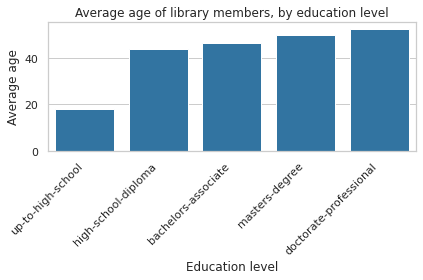

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
g = sns.barplot(
    x="education_level",
    y="age_average",
    data=edu_average_ages.toPandas().sort_values("age_average"),
    color="#1f77b4",
)
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment="right")
plt.title("Average age of library members, by education level")
plt.xlabel("Education level")
plt.ylabel("Average age")
plt.tight_layout()
plt.show()

In [7]:
young_ages = list(range(5, 18))  # [5, 6, ..., 17]
young_age_keys = KeySet.from_dict({"age": young_ages})
young_age_query = (
    QueryBuilder("members")
    .groupby(young_age_keys)
    .count()
)
young_age_counts = session.evaluate(
    young_age_query,
    PureDPBudget(0.1)
)

/home/anshu/Work/tumult_labs/env/lib/python3.7/site-packages/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


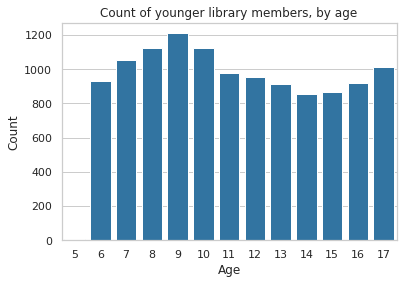

In [9]:
sns.barplot(
    x="age",
    y="count",
    data=young_age_counts.toPandas().sort_values("age"),
    color="#1f77b4",
)
plt.title("Count of younger library members, by age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

**Multiple columns**

In [10]:
teen_edu_keys = KeySet.from_dict({
    "age": list(range(13, 22)), # [13, 14, ..., 21]
    "education_level": [
        "up-to-high-school",
        "high-school-diploma",
        "bachelors-associate",
        "masters-degree",
        "doctorate-professional",
    ],
})

In [11]:
teen_edu_df = teen_edu_keys.dataframe()
teen_edu_df.sort("age", "education_level").show(n=12, truncate=False)

+---+----------------------+
|age|education_level       |
+---+----------------------+
|13 |bachelors-associate   |
|13 |doctorate-professional|
|13 |high-school-diploma   |
|13 |masters-degree        |
|13 |up-to-high-school     |
|14 |bachelors-associate   |
|14 |doctorate-professional|
|14 |high-school-diploma   |
|14 |masters-degree        |
|14 |up-to-high-school     |
|15 |bachelors-associate   |
|15 |doctorate-professional|
+---+----------------------+
only showing top 12 rows



In [12]:
teen_edu_subset_keys_df = spark.createDataFrame(
    [
        (13, "up-to-high-school"),
        (14, "up-to-high-school"),
        (15, "up-to-high-school"),
        (16, "up-to-high-school"),
        (17, "up-to-high-school"),
        (17, "high-school-diploma"),
        (18, "up-to-high-school"),
        (18, "high-school-diploma"),
        (19, "up-to-high-school"),
        (19, "high-school-diploma"),
        (19, "bachelors-associate"),
        (20, "up-to-high-school"),
        (20, "high-school-diploma"),
        (20, "bachelors-associate"),
        (21, "up-to-high-school"),
        (21, "high-school-diploma"),
        (21, "bachelors-associate"),
    ],
    ["age", "education_level"],
)
teen_edu_subset_keys = KeySet.from_dataframe(teen_edu_subset_keys_df)

In [13]:
teen_edu_query = (
    QueryBuilder("members")
    .groupby(teen_edu_keys)
    .count()
)
teen_edu_counts = session.evaluate(
    teen_edu_query,
    PureDPBudget(0.2),
)

/home/anshu/Work/tumult_labs/env/lib/python3.7/site-packages/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


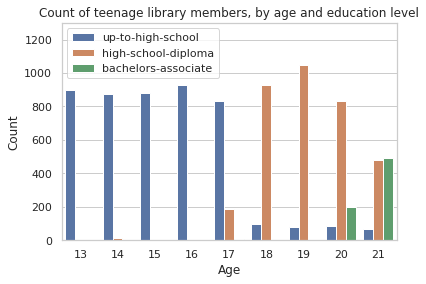

In [14]:
edu_order = ["up-to-high-school", "high-school-diploma", "bachelors-associate"]
sns.barplot(
    x="age",
    y="count",
    hue="education_level",
    hue_order=edu_order,
    data=teen_edu_counts.toPandas()
)
plt.ylim(0, 1300)
plt.title("Count of teenage library members, by age and education level")
plt.xlabel("Age")
plt.ylabel("Count")
plt.legend(loc="upper left")
plt.show()

**Cross-product**

In [15]:
teen_edu_keys = KeySet.from_dict({
    "age": list(range(13, 22)), # [13, 14, ..., 21]
    "education_level": [
        "up-to-high-school",
        "high-school-diploma",
        "bachelors-associate",
        "masters-degree",
        "doctorate-professional",
    ],
})

In [16]:
teen_keys = KeySet.from_dict({
    "age": list(range(13, 22)), # [13, 14, ..., 21]
})
edu_keys = KeySet.from_dict({
    "education_level": [
        "up-to-high-school",
        "high-school-diploma",
        "bachelors-associate",
        "masters-degree",
        "doctorate-professional",
    ],
})

print(teen_edu_keys == teen_keys * edu_keys)

True


In [17]:
print(edu_keys == teen_edu_keys["education_level"])


True


**Filters**

In [18]:
teen_edu_subset_keys_df = spark.createDataFrame(
    [
        (13, "up-to-high-school"),
        (14, "up-to-high-school"),
        (15, "up-to-high-school"),
        (16, "up-to-high-school"),
        (17, "up-to-high-school"),
        (17, "high-school-diploma"),
        (18, "up-to-high-school"),
        (18, "high-school-diploma"),
        (19, "up-to-high-school"),
        (19, "high-school-diploma"),
        (19, "bachelors-associate"),
        (20, "up-to-high-school"),
        (20, "high-school-diploma"),
        (20, "bachelors-associate"),
        (21, "up-to-high-school"),
        (21, "high-school-diploma"),
        (21, "bachelors-associate"),
    ],
    ["age", "education_level"],
)
teen_edu_subset_keys = KeySet.from_dataframe(teen_edu_subset_keys_df)

In [19]:
teen_edu_keys_filtered = teen_edu_keys.filter("""
    education_level != 'masters-degree'
    AND education_level != 'doctorate-professional'
    AND NOT (education_level = 'bachelors-associate' AND age < 19)
    AND NOT (education_level = 'high-school-diploma' AND age < 17)
""")
print(teen_edu_keys_filtered == teen_edu_subset_keys)

True
